# Extend the Temperature analysis using suitable datasets to get a trend over a long period (e.g. back to 1950)


General plan

- repeat using NASA GISS and Peter's population data
- adapt ERA approach to longer term by using same recent past base 1986-2008 but longer term population


In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import rasterio
from rasterio.io import MemoryFile
from rasterio.warp import reproject, Resampling
from affine import Affine

import population_tools
from config import DATA_SRC, POP_DATA_SRC

In [3]:
# NOTE: giss is already calculated as a temperature difference

nasa_giss_anom = DATA_SRC / 'weather' / 'nasa_giss' / 'air.2x2.1200.mon.anom.comb.nc'
nasa_giss = xr.open_dataset(str(nasa_giss_anom))

In [15]:
nasa_giss_cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(nasa_giss.lat))
# summer_anom_ts = (summer_anom.sel(year=slice('2000','2016')) * cos_lat).mean(dim=['latitude', 'longitude'])



In [ ]:
# clim_t = era_climatology.temperature_2m

# def sub_months(era_t_yr):
#     """Swap in the time axis so the datasets auto-align
#     """
#     clim_t['time'] = era_t_yr.time
#     return era_t_yr - clim_t
    
# delta_t = era_weather.temperature_2m.groupby('time.year').apply(sub_months)



In [16]:
def collect_summer_delta(delta_t):
    """Wrap in a function to clear temporary vars from memory"""
    # northern hemisphere
    lat_north = delta_t.lat[delta_t.lat >= 0]
    lat_south = delta_t.lat[delta_t.lat < 0]

    # Summer North
    summer_jja = delta_t['time.season'] == 'JJA'

    # Summer South
    summer_djf = delta_t['time.season'] == 'DJF'

    nh = delta_t.sel(time=summer_jja).groupby('time.year').mean(dim='time')
    sh = delta_t.sel(time=summer_djf).groupby('time.year').mean(dim='time')

    summer_anom = xr.concat([nh.sel(lat=lat_north),  
                             sh.sel(lat=lat_south)], dim='lat')
    return summer_anom

summer_anom = collect_summer_delta(nasa_giss.air)

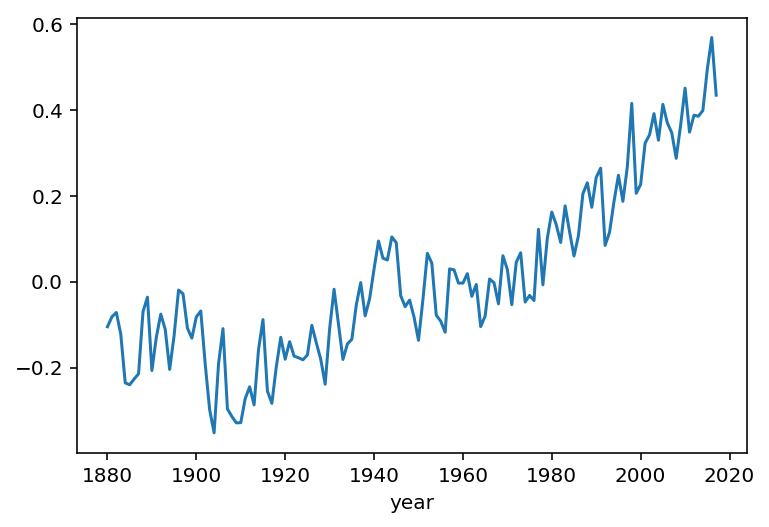

In [18]:
summer_anom_ts = (summer_anom * nasa_giss_cos_lat).mean(dim=['lat', 'lon'])
summer_anom_ts.plot()


### Now project to population

### Copied from Peter

In [ ]:

# Regrid temperature onto population grid
ntime=len(years_giss)
temp_pop_f=np.zeros(ntime)
temp_pop_i=np.zeros(ntime)
temp_area=np.zeros(ntime)
weight_area=np.cos(lats*np.pi/180.0)
# Calculate mean temperature exposure for human population
for itime in range(0, ntime):
    dTgiss=tmp[itime,:,:]
    dT = basemap.interp(dTgiss,lons_giss,lats_giss, \
                     lons,lats,checkbounds=False,masked=False,order=1)
    weight_pop_i=wt_pop[0,:,:]   
    weight_pop_f=wt_pop[npops-1,:,:]  
    temp_pop_i[itime]=sum(dT*weight_pop_i)/sum(weight_pop_i)   
    temp_pop_f[itime]=sum(dT*weight_pop_f)/sum(weight_pop_f)  
    temp_area[itime]=sum(dT*weight_area)/sum(weight_area)    